# APPLICATIONS OF MARKOV DECISION PROCESSES
---
In this notebook we will take a look at some indicative applications of markov decision processes. 
We will cover content from [`mdp.py`](https://github.com/aimacode/aima-python/blob/master/mdp.py), for **Chapter 17 Making Complex Decisions** of Stuart Russel's and Peter Norvig's book [*Artificial Intelligence: A Modern Approach*](http://aima.cs.berkeley.edu/).


In [1]:
from mdp import *
from notebook import psource, pseudocode

## CONTENTS
- Simple MDP
    - State dependent reward function
    - State and action dependent reward function
    - State, action and next state dependent reward function
- Grid MDP
    - Pathfinding problem
- POMDP
    - Two state POMDP

## SIMPLE MDP
---
### State dependent reward function

Markov Decision Processes are formally described as processes that follow the Markov property which states that "The future is independent of the past given the present". 
MDPs formally describe environments for reinforcement learning and we assume that the environment is *fully observable*. 
Let us take a toy example MDP and solve it using the functions in `mdp.py`.
This is a simple example adapted from a [similar problem](http://www0.cs.ucl.ac.uk/staff/D.Silver/web/Teaching_files/MDP.pdf) by Dr. David Silver, tweaked to fit the limitations of the current functions.
![title](images/mdp-b.png)

Let's say you're a student attending lectures in a university.
There are three lectures you need to attend on a given day.
<br>
Attending the first lecture gives you 4 points of reward.
After the first lecture, you have a 0.6 probability to continue into the second one, yielding 6 more points of reward.
<br>
But, with a probability of 0.4, you get distracted and start using Facebook instead and get a reward of -1.
From then onwards, you really can't let go of Facebook and there's just a 0.1 probability that you will concentrate back on the lecture.
<br>
After the second lecture, you have an equal chance of attending the next lecture or just falling asleep.
Falling asleep is the terminal state and yields you no reward, but continuing on to the final lecture gives you a big reward of 10 points.
<br>
From there on, you have a 40% chance of going to study and reach the terminal state, 
but a 60% chance of going to the pub with your friends instead. 
You end up drunk and don't know which lecture to attend, so you go to one of the lectures according to the probabilities given above.
<br> 
We now have an outline of our stochastic environment and we need to maximize our reward by solving this MDP.
<br>
<br>
We first have to define our Transition Matrix as a nested dictionary to fit the requirements of the MDP class.

In [2]:
t = {
    'leisure': {
                    'facebook': {'leisure':0.9, 'class1':0.1},
                    'quit': {'leisure':0.1, 'class1':0.9},
                    'study': {},
                    'sleep': {},
                    'pub': {}
               },
    'class1': {
                    'study': {'class2':0.6, 'leisure':0.4},
                    'facebook': {'class2':0.4, 'leisure':0.6},
                    'quit': {},
                    'sleep': {},
                    'pub': {}
              },
    'class2': {
                    'study': {'class3':0.5, 'end':0.5},
                    'sleep': {'end':0.5, 'class3':0.5},
                    'facebook': {},
                    'quit': {},
                    'pub': {},
              },
    'class3': {
                    'study': {'end':0.6, 'class1':0.08, 'class2':0.16, 'class3':0.16},
                    'pub': {'end':0.4, 'class1':0.12, 'class2':0.24, 'class3':0.24},
                    'facebook': {},
                    'quit': {},
                    'sleep': {}
              },
    'end': {}
}

We now need to define the reward for each state.

In [3]:
rewards = {
    'class1': 4,
    'class2': 6,
    'class3': 10,
    'leisure': -1,
    'end': 0
}

This MDP has only one terminal state.

In [4]:
terminals = ['end']

Let's now set the initial state to Class 1.

In [5]:
init = 'class1'

We will write a CustomMDP class to extend the MDP class for the problem at hand. 
This class will implement the `T` method to implement the transition model. This is the exact same class as given in [`mdp.ipynb`](https://github.com/aimacode/aima-python/blob/master/mdp.ipynb#MDP).

In [6]:
class CustomMDP(MDP):

    def __init__(self, transition_matrix, rewards, terminals, init, gamma=.9):
        # All possible actions.
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix[state])
        actlist = list(set(actlist))
        print(actlist)

        MDP.__init__(self, init, actlist, terminals=terminals, gamma=gamma)
        self.t = transition_matrix
        self.reward = rewards
        for state in self.t:
            self.states.add(state)

    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else: 
            return [(prob, new_state) for new_state, prob in self.t[state][action].items()]

We now need an instance of this class.

In [7]:
mdp = CustomMDP(t, rewards, terminals, init, gamma=.9)

['quit', 'sleep', 'study', 'pub', 'facebook']


The utility of each state can be found by `value_iteration`.

In [8]:
value_iteration(mdp)

{'class1': 16.90340650279542,
 'class2': 14.597383430869879,
 'class3': 19.10533144728953,
 'end': 0.0,
 'leisure': 13.946891353066082}

Now that we can compute the utility values, we can find the best policy.

In [9]:
pi = best_policy(mdp, value_iteration(mdp, .01))

`pi` stores the best action for each state.

In [10]:
print(pi)

{'class2': 'sleep', 'class3': 'pub', 'end': None, 'class1': 'study', 'leisure': 'quit'}


We can confirm that this is the best policy by verifying this result against `policy_iteration`.

In [11]:
policy_iteration(mdp)

{'class1': 'study',
 'class2': 'sleep',
 'class3': 'pub',
 'end': None,
 'leisure': 'quit'}

Everything looks perfect, but let us look at another possibility for an MDP.
<br>
Till now we have only dealt with rewards that the agent gets while it is **on** a particular state.
What if we want to have different rewards for a state depending on the action that the agent takes next. 
The agent gets the reward _during its transition_ to the next state.
<br>
For the sake of clarity, we will call this the _transition reward_ and we will call this kind of MDP a _dynamic_ MDP. 
This is not a conventional term, we just use it to minimize confusion between the two.
<br>
This next section deals with how to create and solve a dynamic MDP.

### State and action dependent reward function
Let us consider a very similar problem, but this time, we do not have rewards _on_ states, 
instead, we have rewards on the transitions between states. 
This state diagram will make it clearer.
![title](images/mdp-c.png)

A very similar scenario as the previous problem, but we have different rewards for the same state depending on the action taken.
<br>
To deal with this, we just need to change the `R` method of the `MDP` class, but to prevent confusion, we will write a new similar class `DMDP`.

In [12]:
class DMDP:

    """A Markov Decision Process, defined by an initial state, transition model,
    and reward model. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. The reward function is very similar.
    We also keep track of the possible states,
    terminal states, and actions for each state."""

    def __init__(self, init, actlist, terminals, transitions={}, rewards={}, states=None, gamma=.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        if states:
            self.states = states
        else:
            self.states = set()
        self.init = init
        self.actlist = actlist
        self.terminals = terminals
        self.transitions = transitions
        self.rewards = rewards
        self.gamma = gamma

    def R(self, state, action):
        """Return a numeric reward for this state and this action."""
        if (self.rewards == {}):
            raise ValueError('Reward model is missing')
        else:
            return self.rewards[state][action]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""
        if(self.transitions == {}):
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Set of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""
        if state in self.terminals:
            return [None]
        else:
            return self.actlist

The transition model will be the same

In [13]:
t = {
    'leisure': {
                    'facebook': {'leisure':0.9, 'class1':0.1},
                    'quit': {'leisure':0.1, 'class1':0.9},
                    'study': {},
                    'sleep': {},
                    'pub': {}
               },
    'class1': {
                    'study': {'class2':0.6, 'leisure':0.4},
                    'facebook': {'class2':0.4, 'leisure':0.6},
                    'quit': {},
                    'sleep': {},
                    'pub': {}
              },
    'class2': {
                    'study': {'class3':0.5, 'end':0.5},
                    'sleep': {'end':0.5, 'class3':0.5},
                    'facebook': {},
                    'quit': {},
                    'pub': {},
              },
    'class3': {
                    'study': {'end':0.6, 'class1':0.08, 'class2':0.16, 'class3':0.16},
                    'pub': {'end':0.4, 'class1':0.12, 'class2':0.24, 'class3':0.24},
                    'facebook': {},
                    'quit': {},
                    'sleep': {}
              },
    'end': {}
}

The reward model will be a dictionary very similar to the transition dictionary with a reward for every action for every state.

In [14]:
r = {
    'leisure': {
        'facebook':-1,
        'quit':0,
        'study':0,
        'sleep':0,
        'pub':0
    },
    'class1': {
        'study':-2,
        'facebook':-1,
        'quit':0,
        'sleep':0,
        'pub':0
    },
    'class2': {
        'study':-2,
        'sleep':0,
        'facebook':0,
        'quit':0,
        'pub':0
    },
    'class3': {
        'study':10,
        'pub':1,
        'facebook':0,
        'quit':0,
        'sleep':0
    },
    'end': {
        'study':0,
        'pub':0,
        'facebook':0,
        'quit':0,
        'sleep':0
    }
}

The MDP has only one terminal state

In [15]:
terminals = ['end']

Let's now set the initial state to Class 1.

In [16]:
init = 'class1'

We will write a CustomDMDP class to extend the DMDP class for the problem at hand.
This class will implement everything that the previous CustomMDP class implements along with a new reward model.

In [17]:
class CustomDMDP(DMDP):
    
    def __init__(self, transition_matrix, rewards, terminals, init, gamma=.9):
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix[state])
        actlist = list(set(actlist))
        print(actlist)
        
        DMDP.__init__(self, init, actlist, terminals=terminals, gamma=gamma)
        self.t = transition_matrix
        self.rewards = rewards
        for state in self.t:
            self.states.add(state)
            
            
    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else:
            return [(prob, new_state) for new_state, prob in self.t[state][action].items()]
        
    def R(self, state, action):
        if action is None:
            return 0
        else:
            return self.rewards[state][action]

One thing we haven't thought about yet is that the `value_iteration` algorithm won't work now that the reward model is changed.
It will be quite similar to the one we currently have nonetheless.

The Bellman update equation now is defined as follows

$$U(s)=\max_{a\epsilon A(s)}\bigg[R(s, a) + \gamma\sum_{s'}P(s'\ |\ s,a)U(s')\bigg]$$

It is not difficult to see that the update equation we have been using till now is just a special case of this more generalized equation. 
We also need to max over the reward function now as the reward function is action dependent as well.
<br>
We will use this to write a function to carry out value iteration, very similar to the one we are familiar with.

In [18]:
def value_iteration_dmdp(dmdp, epsilon=0.001):
    U1 = {s: 0 for s in dmdp.states}
    R, T, gamma = dmdp.R, dmdp.T, dmdp.gamma
    while True:
        U = U1.copy()
        delta = 0
        for s in dmdp.states:
            U1[s] = max([(R(s, a) + gamma*sum([(p*U[s1]) for (p, s1) in T(s, a)])) for a in dmdp.actions(s)])
            delta = max(delta, abs(U1[s] - U[s]))
        if delta < epsilon * (1 - gamma) / gamma:
            return U

We're all set.
Let's instantiate our class.

In [19]:
dmdp = CustomDMDP(t, r, terminals, init, gamma=.9)

['quit', 'sleep', 'study', 'pub', 'facebook']


Calculate utility values by calling `value_iteration_dmdp`.

In [20]:
value_iteration_dmdp(dmdp)

{'class1': 2.0756895004431364,
 'class2': 5.772550326127298,
 'class3': 12.827904448229472,
 'end': 0.0,
 'leisure': 1.8474896554396596}

These are the expected utility values for our new MDP.
<br>
As you might have guessed, we cannot use the old `best_policy` function to find the best policy.
So we will write our own.
But, before that we need a helper function to calculate the expected utility value given a state and an action.

In [21]:
def expected_utility_dmdp(a, s, U, dmdp):
    return dmdp.R(s, a) + dmdp.gamma*sum([(p*U[s1]) for (p, s1) in dmdp.T(s, a)])

Now we write our modified `best_policy` function.

In [22]:
from utils import argmax
def best_policy_dmdp(dmdp, U):
    pi = {}
    for s in dmdp.states:
        pi[s] = argmax(dmdp.actions(s), key=lambda a: expected_utility_dmdp(a, s, U, dmdp))
    return pi

Find the best policy.

In [23]:
pi = best_policy_dmdp(dmdp, value_iteration_dmdp(dmdp, .01))
print(pi)

{'class2': 'sleep', 'class3': 'study', 'end': None, 'class1': 'facebook', 'leisure': 'quit'}


From this, we can infer that `value_iteration_dmdp` tries to minimize the negative reward. 
Since we don't have rewards for states now, the algorithm takes the action that would try to avoid getting negative rewards and take the lesser of two evils if all rewards are negative.
You might also want to have state rewards alongside transition rewards. 
Perhaps you can do that yourself now that the difficult part has been done.
<br>

### State, action and next-state dependent reward function

For truly stochastic environments, 
we have noticed that taking an action from a particular state doesn't always do what we want it to. 
Instead, for every action taken from a particular state, 
it might be possible to reach a different state each time depending on the transition probabilities. 
What if we want different rewards for each state, action and next-state triplet? 
Mathematically, we now want a reward function of the form R(s, a, s') for our MDP. 
This section shows how we can tweak the MDP class to achieve this.
<br>

Let's now take a different problem statement. 
The one we are working with is a bit too simple.
Consider a taxi that serves three adjacent towns A, B, and C.
Each time the taxi discharges a passenger, the driver must choose from three possible actions:
1. Cruise the streets looking for a passenger.
2. Go to the nearest taxi stand.
3. Wait for a radio call from the dispatcher with instructions.
<br>
Subject to the constraint that the taxi driver cannot do the third action in town B because of distance and poor reception.

Let's model our MDP.
<br>
The MDP has three states, namely A, B and C.
<br>
It has three actions, namely 1, 2 and 3.
<br>
Action sets:
<br>
$K_{a}$ = {1, 2, 3}
<br>
$K_{b}$ = {1, 2}
<br>
$K_{c}$ = {1, 2, 3}
<br>

We have the following transition probability matrices:
<br>
<br>
Action 1: Cruising streets  
<br>
$\\
    P^{1} = 
    \left[ {\begin{array}{ccc}
    \frac{1}{2} & \frac{1}{4} & \frac{1}{4} \\
    \frac{1}{2} & 0 & \frac{1}{2} \\
    \frac{1}{4} & \frac{1}{4} & \frac{1}{2} \\
    \end{array}}\right] \\
    \\
    $
<br>
<br>
Action 2: Waiting at the taxi stand      
<br>
$\\
    P^{2} = 
    \left[ {\begin{array}{ccc}
    \frac{1}{16} & \frac{3}{4} & \frac{3}{16} \\
    \frac{1}{16} & \frac{7}{8} & \frac{1}{16} \\
    \frac{1}{8} & \frac{3}{4} & \frac{1}{8} \\
    \end{array}}\right] \\
    \\
    $
<br>
<br>
Action 3: Waiting for dispatch     
<br>
$\\
    P^{3} =
    \left[ {\begin{array}{ccc}
    \frac{1}{4} & \frac{1}{8} & \frac{5}{8} \\
    0 & 1 & 0 \\
    \frac{3}{4} & \frac{1}{16} & \frac{3}{16} \\
    \end{array}}\right] \\
    \\
    $
<br>
<br>
For the sake of readability, we will call the states A, B and C and the actions 'cruise', 'stand' and 'dispatch'.
We will now build the transition model as a dictionary using these matrices.

In [24]:
t = {
    'A': {
        'cruise': {'A':0.5, 'B':0.25, 'C':0.25},
        'stand': {'A':0.0625, 'B':0.75, 'C':0.1875},
        'dispatch': {'A':0.25, 'B':0.125, 'C':0.625}
    },
    'B': {
        'cruise': {'A':0.5, 'B':0, 'C':0.5},
        'stand': {'A':0.0625, 'B':0.875, 'C':0.0625},
        'dispatch': {'A':0, 'B':1, 'C':0}
    },
    'C': {
        'cruise': {'A':0.25, 'B':0.25, 'C':0.5},
        'stand': {'A':0.125, 'B':0.75, 'C':0.125},
        'dispatch': {'A':0.75, 'B':0.0625, 'C':0.1875}
    }
}

The reward matrices for the problem are as follows:
<br>
<br>
Action 1: Cruising streets  
<br>
$\\
    R^{1} = 
    \left[ {\begin{array}{ccc}
    10 & 4 & 8 \\
    14 & 0 & 18 \\
    10 & 2 & 8 \\
    \end{array}}\right] \\
    \\
    $
<br>
<br>
Action 2: Waiting at the taxi stand  
<br>
$\\
    R^{2} = 
    \left[ {\begin{array}{ccc}
    8 & 2 & 4 \\
    8 & 16 & 8 \\
    6 & 4 & 2\\
    \end{array}}\right] \\
    \\
    $
<br>
<br>
Action 3: Waiting for dispatch  
<br>
$\\
    R^{3} = 
    \left[ {\begin{array}{ccc}
    4 & 6 & 4 \\
    0 & 0 & 0 \\
    4 & 0 & 8\\
    \end{array}}\right] \\
    \\
    $
<br>
<br>
We now build the reward model as a dictionary using these matrices.

In [25]:
r = {
    'A': {
        'cruise': {'A':10, 'B':4, 'C':8},
        'stand': {'A':8, 'B':2, 'C':4},
        'dispatch': {'A':4, 'B':6, 'C':4}
    },
    'B': {
        'cruise': {'A':14, 'B':0, 'C':18},
        'stand': {'A':8, 'B':16, 'C':8},
        'dispatch': {'A':0, 'B':0, 'C':0}
    },
    'C': {
        'cruise': {'A':10, 'B':2, 'C':18},
        'stand': {'A':6, 'B':4, 'C':2},
        'dispatch': {'A':4, 'B':0, 'C':8}
    }
}

The Bellman update equation now is defined as follows

$$U(s)=\max_{a\epsilon A(s)}\sum_{s'}P(s'\ |\ s,a)(R(s'\ |\ s,a) + \gamma U(s'))$$

It is not difficult to see that all the update equations we have used till now is just a special case of this more generalized equation. 
If we did not have next-state-dependent rewards, the first term inside the summation exactly sums up to R(s, a) or the state-reward for a particular action and we would get the update equation used in the previous problem.
If we did not have action dependent rewards, the first term inside the summation sums up to R(s) or the state-reward and we would get the first update equation used in `mdp.ipynb`.
<br>
For example, as we have the same reward regardless of the action, let's consider a reward of **r** units for a particular state and let's assume the transition probabilities to be 0.1, 0.2, 0.3 and 0.4 for 4 possible actions for that state.
We will further assume that a particular action in a state leads to the same state every time we take that action.
The first term inside the summation for this case will evaluate to (0.1 + 0.2 + 0.3 + 0.4)r = r which is equal to R(s) in the first update equation.
<br>
There are many ways to write value iteration for this situation, but we will go with the most intuitive method.
One that can be implemented with minor alterations to the existing `value_iteration` algorithm.
<br>
Our `DMDP` class will be slightly different.
More specifically, the `R` method will have one more index to go through now that we have three levels of nesting in the reward model.
We will call the new class `DMDP2` as I have run out of creative names.

In [26]:
class DMDP2:

    """A Markov Decision Process, defined by an initial state, transition model,
    and reward model. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. The reward function is very similar.
    We also keep track of the possible states,
    terminal states, and actions for each state."""

    def __init__(self, init, actlist, terminals, transitions={}, rewards={}, states=None, gamma=.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        if states:
            self.states = states
        else:
            self.states = set()
        self.init = init
        self.actlist = actlist
        self.terminals = terminals
        self.transitions = transitions
        self.rewards = rewards
        self.gamma = gamma

    def R(self, state, action, state_):
        """Return a numeric reward for this state, this action and the next state_"""
        if (self.rewards == {}):
            raise ValueError('Reward model is missing')
        else:
            return self.rewards[state][action][state_]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""
        if(self.transitions == {}):
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Set of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""
        if state in self.terminals:
            return [None]
        else:
            return self.actlist
        
    def actions(self, state):
        """Set of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""
        if state in self.terminals:
            return [None]
        else:
            return self.actlist

Only the `R` method is different from the previous `DMDP` class.
<br>
Our traditional custom class will be required to implement the transition model and the reward model.
<br>
We call this class `CustomDMDP2`.

In [27]:
class CustomDMDP2(DMDP2):
    
    def __init__(self, transition_matrix, rewards, terminals, init, gamma=.9):
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix[state])
        actlist = list(set(actlist))
        print(actlist)
        
        DMDP2.__init__(self, init, actlist, terminals=terminals, gamma=gamma)
        self.t = transition_matrix
        self.rewards = rewards
        for state in self.t:
            self.states.add(state)
                      
    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else:
            return [(prob, new_state) for new_state, prob in self.t[state][action].items()]
        
    def R(self, state, action, state_):
        if action is None:
            return 0
        else:
            return self.rewards[state][action][state_]

We can finally write value iteration for this problem.
The latest update equation will be used.

In [28]:
def value_iteration_taxi_mdp(dmdp2, epsilon=0.001):
    U1 = {s: 0 for s in dmdp2.states}
    R, T, gamma = dmdp2.R, dmdp2.T, dmdp2.gamma
    while True:
        U = U1.copy()
        delta = 0
        for s in dmdp2.states:
            U1[s] = max([sum([(p*(R(s, a, s1) + gamma*U[s1])) for (p, s1) in T(s, a)]) for a in dmdp2.actions(s)])
            delta = max(delta, abs(U1[s] - U[s]))
        if delta < epsilon * (1 - gamma) / gamma:
            return U

These algorithms can be made more pythonic by using cleverer list comprehensions.
We can also write the variants of value iteration in such a way that all problems are solved using the same base class, regardless of the reward function and the number of arguments it takes.
Quite a few things can be done to refactor the code and reduce repetition, but we have done it this way for the sake of clarity.
Perhaps you can try this as an exercise.
<br>
We now need to define terminals and initial state.

In [29]:
terminals = ['end']
init = 'A'

Let's instantiate our class.

In [30]:
dmdp2 = CustomDMDP2(t, r, terminals, init, gamma=.9)

['stand', 'dispatch', 'cruise']


In [31]:
value_iteration_taxi_mdp(dmdp2)

{'A': 124.4881543573768, 'B': 137.70885410461636, 'C': 129.08041190693115}

These are the expected utility values for the states of our MDP.
Let's proceed to write a helper function to find the expected utility and another to find the best policy.

In [32]:
def expected_utility_dmdp2(a, s, U, dmdp2):
    return sum([(p*(dmdp2.R(s, a, s1) + dmdp2.gamma*U[s1])) for (p, s1) in dmdp2.T(s, a)])

In [33]:
from utils import argmax
def best_policy_dmdp2(dmdp2, U):
    pi = {}
    for s in dmdp2.states:
        pi[s] = argmax(dmdp2.actions(s), key=lambda a: expected_utility_dmdp2(a, s, U, dmdp2))
    return pi

Find the best policy.

In [34]:
pi = best_policy_dmdp2(dmdp2, value_iteration_taxi_mdp(dmdp2, .01))
print(pi)

{'C': 'cruise', 'A': 'stand', 'B': 'stand'}


We have successfully adapted the existing code to a different scenario yet again.
The takeaway from this section is that you can convert the vast majority of reinforcement learning problems into MDPs and solve for the best policy using simple yet efficient tools.

## GRID MDP
---
### Pathfinding Problem
Markov Decision Processes can be used to find the best path through a maze. Let us consider this simple maze.
![title](images/maze.png)

This environment can be formulated as a GridMDP.
<br>
To make the grid matrix, we will consider the state-reward to be -0.1 for every state.
<br>
State (1, 1) will have a reward of -5 to signify that this state is to be prohibited.
<br>
State (9, 9) will have a reward of +5.
This will be the terminal state.
<br>
The matrix can be generated using the GridMDP editor or we can write it ourselves.

In [35]:
grid = [
    [None, None, None, None, None, None, None, None, None, None, None], 
    [None, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, None, +5.0, None], 
    [None, -0.1, None, None, None, None, None, None, None, -0.1, None], 
    [None, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, None], 
    [None, -0.1, None, None, None, None, None, None, None, None, None], 
    [None, -0.1, None, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, None], 
    [None, -0.1, None, None, None, None, None, -0.1, None, -0.1, None], 
    [None, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, None, -0.1, None], 
    [None, None, None, None, None, -0.1, None, -0.1, None, -0.1, None], 
    [None, -5.0, -0.1, -0.1, -0.1, -0.1, None, -0.1, None, -0.1, None], 
    [None, None, None, None, None, None, None, None, None, None, None]
]

We have only one terminal state, (9, 9)

In [36]:
terminals = [(9, 9)]

We define our maze environment below

In [37]:
maze = GridMDP(grid, terminals)

To solve the maze, we can use the `best_policy` function along with `value_iteration`.

In [38]:
pi = best_policy(maze, value_iteration(maze))

This is the heatmap generated by the GridMDP editor using `value_iteration` on this environment
<br>
![title](images/mdp-d.png)
<br>
Let's print out the best policy

In [39]:
from utils import print_table
print_table(maze.to_arrows(pi))

None   None   None   None   None   None   None   None   None   None   None
None   v      <      <      <      <      <      <      None   .      None
None   v      None   None   None   None   None   None   None   ^      None
None   >      >      >      >      >      >      >      >      ^      None
None   ^      None   None   None   None   None   None   None   None   None
None   ^      None   >      >      >      >      v      <      <      None
None   ^      None   None   None   None   None   v      None   ^      None
None   ^      <      <      <      <      <      <      None   ^      None
None   None   None   None   None   ^      None   ^      None   ^      None
None   >      >      >      >      ^      None   ^      None   ^      None
None   None   None   None   None   None   None   None   None   None   None


As you can infer, we can find the path to the terminal state starting from any given state using this policy.
All maze problems can be solved by formulating it as a MDP.

## POMDP
### Two state POMDP
Let's consider a problem where we have two doors, one to our left and one to our right.
One of these doors opens to a room with a tiger in it, and the other one opens to an empty hall.
<br>
We will call our two states `0` and `1` for `left` and `right` respectively.
<br>
The possible actions we can take are as follows:
<br>
1. __Open-left__: Open the left door.
Represented by `0`.
2. __Open-right__: Open the right door.
Represented by `1`.
3. __Listen__: Listen carefully to one side and possibly hear the tiger breathing.
Represented by `2`.

<br>
The possible observations we can get are as follows:
<br>
1. __TL__: Tiger seems to be at the left door.
2. __TR__: Tiger seems to be at the right door.

<br>
The reward function is as follows:
<br>
We get +10 reward for opening the door to the empty hall and we get -100 reward for opening the other door and setting the tiger free.
<br>
Listening costs us -1 reward.
<br>
We want to minimize our chances of setting the tiger free.


Our transition probabilities can be defined as:
<br>
<br>
Action `0` (Open left door)
$\\
    P(0) = 
    \left[ {\begin{array}{cc}
    0.5 & 0.5 \\
    0.5 & 0.5 \\
    \end{array}}\right] \\
    \\
    $
    
Action `1` (Open right door)
$\\
    P(1) = 
    \left[ {\begin{array}{cc}
    0.5 & 0.5 \\
    0.5 & 0.5 \\
    \end{array}}\right] \\
    \\
    $
    
Action `2` (Listen)
$\\
    P(2) = 
    \left[ {\begin{array}{cc}
    1.0 & 0.0 \\
    0.0 & 1.0 \\
    \end{array}}\right] \\
    \\
    $
    
<br>
<br>
Our observation probabilities can be defined as:
<br>
<br>
$\\
    O(0) = 
    \left[ {\begin{array}{ccc}
    Open left & TL & TR \\
    Tiger: left & 0.5 & 0.5 \\
    Tiger: right & 0.5 & 0.5 \\
    \end{array}}\right] \\
    \\
    $

$\\
    O(1) = 
    \left[ {\begin{array}{ccc}
    Open right & TL & TR \\
    Tiger: left & 0.5 & 0.5 \\
    Tiger: right & 0.5 & 0.5 \\
    \end{array}}\right] \\
    \\
    $

$\\
    O(2) = 
    \left[ {\begin{array}{ccc}
    Listen & TL & TR \\
    Tiger: left & 0.85 & 0.15 \\
    Tiger: right & 0.15 & 0.85 \\
    \end{array}}\right] \\
    \\
    $

<br>
<br>
The rewards of this POMDP are defined as:
<br>
<br>
$\\
    R(0) = 
    \left[ {\begin{array}{cc}
    Openleft & Reward \\
    Tiger: left & -100 \\
    Tiger: right & +10 \\
    \end{array}}\right] \\
    \\
    $
    
$\\
    R(1) = 
    \left[ {\begin{array}{cc}
    Openright & Reward \\
    Tiger: left & +10 \\
    Tiger: right & -100 \\
    \end{array}}\right] \\
    \\
    $
    
$\\
    R(2) = 
    \left[ {\begin{array}{cc}
    Listen & Reward \\
    Tiger: left & -1 \\
    Tiger: right & -1 \\
    \end{array}}\right] \\
    \\
    $
    
<br>
Based on these matrices, we will initialize our variables.

Let's first define our transition state.

In [40]:
t_prob = [[[0.5, 0.5], 
           [0.5, 0.5]], 
          
          [[0.5, 0.5], 
           [0.5, 0.5]], 
          
          [[1.0, 0.0], 
           [0.0, 1.0]]]

Followed by the observation model.

In [41]:
e_prob = [[[0.5, 0.5], 
           [0.5, 0.5]], 
          
          [[0.5, 0.5], 
           [0.5, 0.5]], 
          
          [[0.85, 0.15], 
           [0.15, 0.85]]]

And the reward model.

In [42]:
rewards = [[-100, 10], 
           [10, -100], 
           [-1, -1]]

Let's now define our states, observations and actions.
<br>
We will use `gamma` = 0.95 for this example.
<br>

In [43]:
# 0: open-left, 1: open-right, 2: listen
actions = ('0', '1', '2')
# 0: left, 1: right
states = ('0', '1')

gamma = 0.95

We have all the required variables to instantiate an object of the `POMDP` class.

In [44]:
pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)

We can now find the utility function by running `pomdp_value_iteration` on our `pomdp` object.

In [45]:
utility = pomdp_value_iteration(pomdp, epsilon=3)
utility

defaultdict(list,
            {'0': [array([-83.05169196,  26.94830804])],
             '1': [array([ 26.94830804, -83.05169196])],
             '2': [array([23.55049363, -0.76359097]),
              array([23.55049363, -0.76359097]),
              array([23.55049363, -0.76359097]),
              array([23.55049363, -0.76359097]),
              array([23.24120177,  1.56028929]),
              array([23.24120177,  1.56028929]),
              array([23.24120177,  1.56028929]),
              array([20.0874279 , 15.03900771]),
              array([20.0874279 , 15.03900771]),
              array([20.0874279 , 15.03900771]),
              array([20.0874279 , 15.03900771]),
              array([17.91696135, 17.91696135]),
              array([17.91696135, 17.91696135]),
              array([17.91696135, 17.91696135]),
              array([17.91696135, 17.91696135]),
              array([17.91696135, 17.91696135]),
              array([15.03900771, 20.0874279 ]),
              array([15.039007

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_utility(utility):
    open_left = utility['0'][0]
    open_right = utility['1'][0]
    listen_left = utility['2'][0]
    listen_right = utility['2'][-1]
    left = (open_left[0] - listen_left[0]) / (open_left[0] - listen_left[0] + listen_left[1] - open_left[1])
    right = (open_right[0] - listen_right[0]) / (open_right[0] - listen_right[0] + listen_right[1] - open_right[1])
    
    colors = ['g', 'b', 'k']
    for action in utility:
        for value in utility[action]:
            plt.plot(value, color=colors[int(action)])
    plt.vlines([left, right], -10, 35, linestyles='dashed', colors='c')
    plt.ylim(-10, 35)
    plt.xlim(0, 1)
    plt.text(left/2 - 0.35, 30, 'open-left')
    plt.text((right + left)/2 - 0.04, 30, 'listen')
    plt.text((right + 1)/2 + 0.22, 30, 'open-right')
    plt.show()

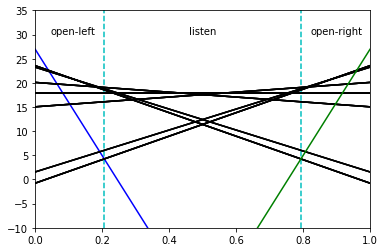

In [47]:
plot_utility(utility)

Hence, we get a piecewise-continuous utility function consistent with the given POMDP.